In [1]:
# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import regex as re
import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from collections import Counter

In [2]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
        
# remove labels that have less than m occurrences
m = 0

labels_list = df['confirmed'].tolist()
labels_list = sum(labels_list, [])
c = Counter(labels_list)
for i in range(len(df)):
    to_remove = []
    
    # find labels that should be removed 
    for j in range(len(df['confirmed'][i])):
        if c[df['confirmed'][i][j]] < m:
            to_remove.append(j)
            
    # remove the labels
    shift = 0
    for j in range(len(to_remove)):
        df['confirmed'][i].pop(to_remove[j]-shift)
        shift += 1
    
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# remove all rows with no confirmed labels
df = df[df['confirmed'].map(len) > 0]
df = df.reset_index(drop=True)

In [3]:
df.drop('confirmed', inplace=True, axis=1)
df.drop('suggested', inplace=True, axis=1)
#df = df[0:100]
df.head()

,text,labels
0,Slut på medicin.,"[Känd astma, Känd lungsjukdom]"
1,Behöver att prata med psykolog angående använd...,"[Nedstämdhet, Trötthet]"
2,Har fått besvärlig eksem på händerna,"[Hudbesvär, Synliga hudbesvär]"
3,Muskelsvaghet och trötthet känner mig skakig o...,"[Muskelsvaghet, Trötthet]"
4,Svår smärta i vänsterhanden/handleden precis n...,"[Smärta i handled eller fingrar, Förvärras av ..."


In [4]:
# a basic tokenizer to start off with
def basic_tokenization(text):
    text = text.lower()

    tokens = re.sub(r'[^\p{L} ]', '', text).split()
    
    return tokens

test = 'Hej, hur är läget?'
print(basic_tokenization(test))

['hej', 'hur', 'är', 'läget']


In [5]:
# create dictionary that assigns a unique integer id for each word in the embeddings
word2id = {}
id_count = 0

embedding_weights = None

with open('./embeddings/swectors-300dim.txt', encoding='utf-8') as file:
    # initialize the embedding weights matrix with zeros
    dims = [int(x) for x in file.readline().split()]
    print(dims)
    embedding_weights = torch.zeros((dims[0],dims[1]), dtype=torch.float64)    
    
    line = file.readline().split()
    while line != []:
        word2id[line[0]] = id_count
        embedding_weights[id_count,:] = torch.tensor([float(x) for x in line[1:]])
        id_count += 1
        
        line = file.readline()
        line = line.split()
        
        if id_count % 100000 == 0:
            print(id_count)

[192250, 300]
100000


In [6]:
# train a multilabel_binarizer on the labels
labels = df['labels'].tolist()
multilab_bin = MultiLabelBinarizer()
multilab_bin.fit(labels)

# token-ids used for padding and unknown
pad_tok = word2id['<>']
unk_tok = word2id['<>det']

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, word2id, multilab_bin, max_len):
        self.tokenizer = tokenizer
        self.word2id = word2id
        self.multilab_bin = multilab_bin
        self.data = dataframe
        self.text = self.data['text']
        self.labels = self.data['labels']
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())
        
        tokens = self.tokenizer(text)
        # if tokens is empty, add set tokens to ['x']
        if len(tokens) <= 1:
            tokens = ['x']
        
        text_len = len(tokens)
        ids = [0 for i in range(len(tokens))]
        for i in range(len(tokens)):
            if tokens[i] in word2id:
                ids[i] = word2id[tokens[i]]
            else:
                ids[i] = unk_tok
        
        return {
            'lens': text_len,
            'ids': torch.tensor(ids, dtype=torch.long),
            'labels': torch.tensor(np.sum(self.multilab_bin.transform([self.labels[index]]), axis=0), dtype=torch.float)
        }      
    
# collate function for the dataloader
def collate_fn(batch):
    # sort token-id sequences by length
    for_sorting = [(batch[i]['lens'],batch[i]['ids'],batch[0]['labels']) for i in range(len(batch))]
    for_sorting = sorted(for_sorting, key=lambda tup: tup[0], reverse=True)
    
    # pad token-id sequences to max_len_batch
    max_len_batch = for_sorting[0][0]
    
    lens = [0 for i in range(len(batch))]
    ids = torch.zeros((len(batch), max_len_batch), dtype=torch.long)
    labels = torch.zeros((len(batch), len(batch[0]['labels'])))
    
    for i in range(len(batch)):
        temp = torch.tensor([pad_tok for j in range(max_len_batch)])
        temp[:for_sorting[i][0]] = for_sorting[i][1]
        
        lens[i] = for_sorting[i][0]
        ids[i,:] = temp
        labels[i,:] = for_sorting[i][2]
        
    return lens, ids, labels
        

In [7]:
batch_size = 16

# max number of tokens in text
#max_len = 200
max_len = 0
for i in range(len(df['text'])):
    text = df['text'][i]
            
    tokens = basic_tokenization(text)
    
    if len(tokens) > max_len:
        max_len = len(tokens)

print(max_len)

train_dataset, test_dataset = train_test_split(df,
                                        random_state=42,
                                        test_size=0.2,
                                        shuffle=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_set = CustomDataset(train_dataset, basic_tokenization, word2id, multilab_bin, max_len)
test_set = CustomDataset(test_dataset, basic_tokenization, word2id, multilab_bin, max_len)

train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': collate_fn
               }
test_params = {'batch_size': batch_size,
               'shuffle': True,
               'num_workers': 0,
               'collate_fn': collate_fn
              }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

print(f'Train set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

99
Train set: 3027 samples
Test set: 757 samples


In [8]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'

print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

# print the device names
for i in range(torch.cuda.device_count()):
    print(f'Device {i}: {torch.cuda.get_device_name(i)}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1
Device 0: Quadro P520


In [9]:
class RNN(nn.Module):
    def __init__(self, embeddings, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
        self.rnn = nn.LSTM(embeddings.shape[1], hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.sigm = nn.Sigmoid()
        
    # sentences contains padded token-id sequences sorted by length
    def forward(self, sentences, sent_lengths):
        embeds = self.word_embeddings(sentences)
        #print(embeds.shape)
        
        # initialize h0
        #h0 = torch.randn(1*2, sentences.shape[0], sentences.shape[1])
        
        # pack_padded_sequnce so that padded items won't be shown to the RNN
        X = torch.nn.utils.rnn.pack_padded_sequence(embeds, sent_lengths, batch_first=True)
        
        X = X.float()
        _, hc = self.rnn(X)
        
        # make use of the final hidden state
        X = hc[0]
        
        # undo the packing
        #X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        
        # reshape X to fit the linear layer
        #print(X.shape)
        #print(self.hidden_dim)
        #X = X.contiguous()
        X = X.view(-1, 2*self.hidden_dim)
        
        X = self.fc(X)
        X = self.sigm(X)
        
        return X

In [10]:
# compute the loss of an epoch by averaging all batch losses
def epoch_loss(model, data_loader, criterion):
    loss = 0
    batch_count = 0
    
    model.eval()
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            lens, ids, labels = batch
            lens = torch.tensor(lens, dtype=torch.long)#.to(device)
            ids = ids.to(device)
            labels = labels.to(device)
            
            outputs = model(ids, lens)
            loss += criterion(outputs, labels)
            batch_count += 1
    model.train()
    return loss / batch_count

In [11]:
# define the model
output_dim = len(multilab_bin.classes_)
hidden_dim = 400
embedding_weights = embedding_weights.to(device)

model = RNN(embedding_weights, hidden_dim, output_dim)
model.train()
model.to(device)

# number of epochs trained
epochs_trained = 0

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

In [17]:
model.train()

# training loop
learning_rate = 0.00001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
for epoch in range(num_epochs):
    for idx,batch in enumerate(train_loader):
        lens, ids, labels = batch
        lens = torch.tensor(lens, dtype=torch.long)#.to(device)
        ids = ids.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(ids, lens)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # save the losses
    train_losses.append(epoch_loss(model, train_loader, criterion))
    test_losses.append(epoch_loss(model, test_loader, criterion))

    epochs_trained += 1
    
    print(f'End of epoch {epochs_trained}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}')

End of epoch 11, Train Loss: 0.0425072, Test Loss: 0.0424193
End of epoch 12, Train Loss: 0.0411836, Test Loss: 0.0433846
End of epoch 13, Train Loss: 0.0431265, Test Loss: 0.0419359
End of epoch 14, Train Loss: 0.0440535, Test Loss: 0.0502117
End of epoch 15, Train Loss: 0.0427039, Test Loss: 0.0383925
End of epoch 16, Train Loss: 0.0437093, Test Loss: 0.0408589
End of epoch 17, Train Loss: 0.0419721, Test Loss: 0.0405199
End of epoch 18, Train Loss: 0.0443111, Test Loss: 0.0481309
End of epoch 19, Train Loss: 0.0411908, Test Loss: 0.0367024
End of epoch 20, Train Loss: 0.0421413, Test Loss: 0.0417836


In [18]:
# get the predicitons and corresponding labels
def get_pred_true(model, data_loader, D_out):

    y_pred = np.zeros((1,D_out))
    y_true = np.zeros((1,D_out))
  
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            lens, ids, labels = batch
            lens = torch.tensor(lens, dtype=torch.long)#.to(device)
            ids = ids.to(device)
            labels = labels.to(device)
            
            outputs = model(ids, lens)
            
            y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
            y_true = np.concatenate((y_true,np.array(labels.cpu())), axis=0)
            
    return y_pred[1:,:], y_true[1:,:]

model.eval()  
y_pred_temp, y_true = get_pred_true(model, test_loader, output_dim)

Number of labels in training set: 186/197 (94.42 %)
Number of labels in test set: 140/197 (71.07 %)
Number of labels present in both sets: 129/197 (65.48 %)

Micro-average F1-score: 0.28297668476525073
Weighted-average F1-score: 0.136232527986836
Macro-average F1-score: 0.7872657586337123
Accuracy (exact match): 0.13738441215323646
Hamming Loss: 0.01505408069523701


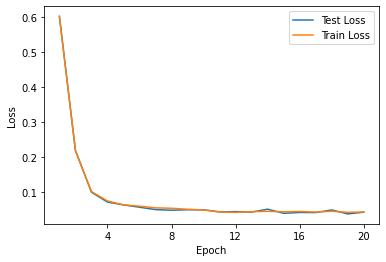

In [19]:
# set all values above threshold to 1, else 0
th = 0.2
y_pred = np.copy(y_pred_temp)
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

# number of labels in test set
#labels_in_test = np.count_nonzero(np.sum(y_true, axis=0))
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)
labels_in_test = np.count_nonzero(label_counts_test)

# number of labels in train set
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
labels_in_train = np.count_nonzero(label_counts_train)

# compute size of intersection between labels in train and test
label_counts_test[label_counts_test > 0] = 1
labels_bin_test = label_counts_test

label_counts_train[label_counts_train > 0] = 1
labels_bin_train = label_counts_train

labels_bin_sum = labels_bin_test + labels_bin_train
labels_intersect = np.count_nonzero(labels_bin_sum[labels_bin_sum == 2])

print(f'Number of labels in training set: {labels_in_train}/{y_true.shape[1]} ({labels_in_train/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels in test set: {labels_in_test}/{y_true.shape[1]} ({labels_in_test/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels present in both sets: {labels_intersect}/{y_true.shape[1]} ({labels_intersect/y_true.shape[1]*100:.2f} %)')
print()
print(f"Micro-average F1-score: {f1_score(y_true, y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_true, y_pred, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_true, y_pred, average='macro', zero_division=1)}")
#print(f"Sample-average Jaccard score: {jaccard_score(y_true, y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_true, y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_true, y_pred)}")

x = [x for x in range(1,len(train_losses)+1)]
xticks = [x*len(train_losses)//5 for x in range(1,6)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(xticks,xticks)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.gca().set_ylim([0,0.1])
plt.show()

In [20]:
word_embeddings = nn.Embedding.from_pretrained(embedding_weights)

word_embeddings(torch.tensor([1,2,3], dtype=torch.long).to(device))

tensor([[ 2.1269e+00, -1.5451e+00,  1.0750e+00, -2.0293e-01, -1.8376e+00,
         -8.3120e-02, -1.0068e-01, -2.8981e+00,  1.1431e+00,  4.4147e-01,
         -6.3511e-01, -1.1318e+00, -9.2508e-02, -2.3185e+00,  2.0088e+00,
          1.6871e-01,  1.3692e+00, -2.2981e+00,  2.1971e+00,  7.3852e-01,
         -2.1624e+00,  8.0845e-01, -1.3576e+00,  3.8323e-01,  2.1305e+00,
          2.1917e+00, -1.7953e+00,  1.3665e-01,  1.3518e+00, -5.1753e-01,
          1.3455e-01,  6.0415e-01, -2.2657e-01, -1.1843e+00,  2.5285e-01,
         -1.1356e+00,  4.5385e-01,  4.5484e-02, -5.1116e-01,  1.6789e+00,
          7.5456e-01,  2.5622e-01, -2.3226e+00,  1.3944e+00, -9.7285e-01,
          1.4166e+00, -2.1429e+00, -1.4608e+00,  1.0985e+00,  1.0250e+00,
          6.6112e-01, -4.6495e-01, -4.4374e-01,  1.7232e+00,  3.0483e-02,
          1.0165e+00, -2.3558e+00,  2.6003e-01, -2.5648e+00, -2.2209e+00,
         -2.5138e+00,  8.5870e-01, -5.1055e-01,  2.0650e+00, -7.4025e-01,
         -3.2325e+00,  1.3513e+00,  4.